In [13]:
%load_ext tensorboard
from datetime import datetime

import numpy as np
import scipy.ndimage
import tensorflow as tf
from tensorflow import keras
from tensorflow import pad
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.layers import Conv3D, ReLU, Input, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import h5py
import SimpleITK as sitk

from adamLRM import AdamLRM
from patches import array_to_patches
from store2hdf5 import store2hdf53D
from utils3D import modcrop3D, shave3D, imadjust3D
import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
def SRReCNN3D(input_shape, depth, nb_filters, kernel_size, padding, to_json=False):
    input_layer = Input(input_shape)
    layer = input_layer

    for i in range(depth+1):
        nf = 1 if i == depth else nb_filters
        padded_layer = pad(layer, [[0, 0], [padding, padding], [padding, padding], [padding, padding], [0, 0]])
        layer = Conv3D(
            filters=nf,
            kernel_size=kernel_size,
            strides=1,
            padding="valid",
            kernel_initializer=RandomNormal(
                mean=0,
                stddev=0.0001
            ),
            bias_initializer=Constant(0)
        )(padded_layer)
        if i < depth:
            layer = ReLU()(layer)

    # add_layer = Add()([input_layer, layer])

    model = Model(input_layer, layer)

    if to_json:
        with open("model.js", "w") as json_model:
            json_model.write(model.to_json())


    return model


def read_hdf5_files(source_file):
    with open(source_file) as sf:
        hdf5_name_files = sf.readlines()
        data = []
        labels = []
        for hdf5_name_file in hdf5_name_files:
            with h5py.File(hdf5_name_file[:-1]) as hdf5data:
                data.extend(list(hdf5data[list(hdf5data.keys())[0]]))
                labels.extend(list(hdf5data[list(hdf5data.keys())[1]]))

    return np.asarray(data), np.asarray(labels)

In [15]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

def launch_training(
        hdf5_source_file, depth, nb_filters, kernel_size, padding
):
    data, labels = read_hdf5_files(hdf5_source_file)
    model = SRReCNN3D(data[0].shape, depth, nb_filters, kernel_size, padding)
    model.compile(optimizer=AdamLRM(learning_rate=0.0001), loss="mse", metrics=[psnr_model], run_eagerly=True)
    
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    history = model.fit(data[0], labels[0], batch_size=4, epochs=2, callbacks=[tensorboard_callback])
    plt.figure(figsize=(11, 3))

    # affichage de la valeur de la fonction de perte
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['loss'])
    plt.title('loss')

    # affichage de la précision de notre réseau sur les données d'apprentissage
    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, history.history['psnr_model'])
    plt.title('psnr')

    return model


def psnr_model(y_pred, y_true):
    return tf.image.psnr(y_pred.numpy(), y_true, np.max(y_pred.numpy())).numpy()

def psnr(y_pred, y_true):
    return tf.image.psnr(y_pred, y_true, np.max(y_pred))

In [16]:
def generate_input_image(hr_image, blur_std):
    blurred_image = scipy.ndimage.filters.gaussian_filter(
        hr_image, sigma=blur_std
    )

    # Downsampling
    low_resolution_image = scipy.ndimage.zoom(
        blurred_image,
        zoom=(1 / float(idxScale) for idxScale in scale),
        order=order
    )
    # write_nii(low_resolution_image, ri_min, ri_max, "lr.nii")

    # Cubic Interpolation
    lr_interpolated_image = scipy.ndimage.zoom(
        low_resolution_image, zoom=scale, order=order
    )

    return lr_interpolated_image

1944 patches have been extracted
1944 patches have been extracted
*) Writing to HDF5 file : data/1010.nii.h5

2400 patches have been extracted
2400 patches have been extracted
*) Writing to HDF5 file : data/1037.nii.h5



d:\python_envs\srm4bmri\lib\site-packages\ipykernel_launcher.py:40: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


Epoch 1/2
1/6 [====>.........................] - ETA: 0s - loss: 0.0333 - psnr_model: 8.1287WARNING:tensorflow:From d:\python_envs\srm4bmri\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
6/6 [==============================] - 4s 612ms/step - loss: 0.0333 - psnr_model: 8.9206
Epoch 2/2
6/6 [==============================] - 2s 381ms/step - loss: 0.0333 - psnr_model: 8.4469


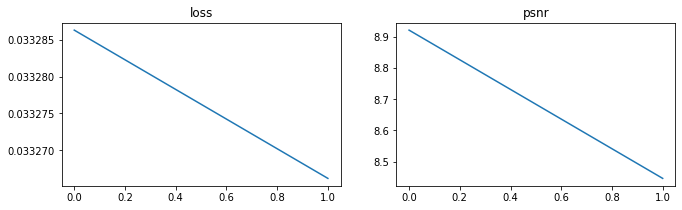

In [17]:
sg = 1
scale = (2, 2, 2)
border = (0, 0, 0)
order = 3
ps = 21
stride = 5
samples = np.inf

image_names = ["1010.nii", "1037.nii"]

hdf5_file = open("data/hdf5data.txt", "w")

for image_name in image_names:
    data_patches = []
    labels_patches = []
    image_path = r"data\\" + image_name
    reference_nifti = sitk.ReadImage(image_path)

    # Get data from NIFTI
    reference_image = np.swapaxes(
        sitk.GetArrayFromImage(reference_nifti), 0, 2
    ).astype('float32')

    ri_max = np.max(reference_image)
    ri_min = np.min(reference_image)

    # Normalization
    reference_image = imadjust3D(reference_image, [0, 1])
    # write_nii(reference_image, ri_min, ri_max, "ref.nii")

    # Modcrop to scale factor
    reference_image = modcrop3D(reference_image, scale)

    # ===== Generate input LR image =====
    interpolated_image = generate_input_image(reference_image, blur_std=1)

    # Shave border
    label_image = shave3D(reference_image, border)
    data_image = shave3D(interpolated_image, border)

    # Extract 3D patches
    data_patch = array_to_patches(
        data_image,
        patch_shape=(ps, ps, ps),
        extraction_step=stride,
        normalization=False
    )

    label_patch = array_to_patches(
        label_image,
        patch_shape=(ps, ps, ps),
        extraction_step=stride,
        normalization=False
    )

    data_patches.append(data_patch)
    labels_patches.append(label_patch)

    data_patches = np.asarray(data_patches).reshape((-1, ps, ps, ps))
    labels_patches = np.asarray(labels_patches).reshape((-1, ps, ps, ps))

    # Add channel axis !
    data_patches = data_patches[:, :, :, :, np.newaxis]
    labels_patches = labels_patches[:, :, :, :, np.newaxis]

    # Rearrange and select samples
    np.random.seed(0)  # makes the random numbers predictable
    random_order = np.random.permutation(
        min(data_patches.shape[0], samples)
    )
    data_patches = data_patches[random_order, :, :, :, :]
    labels_patches = labels_patches[random_order, :, :, :, :]


    # Writing to HDF5
    hdf5name = f"data/{image_name}.h5"
    print(f'*) Writing to HDF5 file : {hdf5name}')
    StartLocation = {'dat': (0, 0, 0, 0, 0), 'lab': (0, 0, 0, 0, 0)}
    CurrentDataLocation = store2hdf53D(
        filename=hdf5name,
        datas=data_patches,
        labels=labels_patches,
        startloc=StartLocation,
        chunksz=64
    )

    hdf5_file.write(hdf5name + "\n")

hdf5_file.close()

launch_training(
    hdf5_file.name,
    depth=10,
    nb_filters=64,
    kernel_size=3,
    padding=1
)

In [19]:
%tensorboard --logdir {logdir}  --host localhost

Reusing TensorBoard on port 6006 (pid 9552), started 0:01:05 ago. (Use '!kill 9552' to kill it.)